# Demo of Action Comet

**Purpose**: Run our Action Comet model for custom image input. Specifically,\
**Input**: Image (we currently limit to actions/objects typically found in kitchen)\
**Output**: Text describing\
(i) **actions** that are happening in the image and objects that participate in action (e.g. boiling egg)\
(ii) **pre-conditions** for the action happening in the image (e.g. water is a pre-condition for boiling)\
(iii) most likely **before and after** (effects) scenarios (e.g. contents of egg will become solid)\
-----------\
You need to swich between two python notebooks for this demo\
(i) **Detectron_demo notebook**: Takes user specified image, detect objects and extract features from it\
(ii) **ActionComet_demo notebook**: Takes image features and generate inference

# Step 1: Detectron_demo notebook
Note: GPU required to run this script.

Simply run cells 1-9 to set up proper environment and define useful functions.

Then upload any image of your choice (we currently limit to actions/objects typically found in kitchen) under Google Drive directory action-comet/action_images/. Then provide name of your uploaded image file under 'filename' variable in cell 10.

Run cell 10 to obtain following for your uploaded image (i) detected objects in the image (ii) extracted image features (iii) .json and .pkl files containing image metadata, which are required by inference module.

# Step 2: ActionComet_demo notebook
Note: GPU is not required but highly recommended to run this script.

Simply run cells 1-4 to set up proper environment.

Run cell 5 to obtain inference.




In [ ]:
# cell 1
# move to the public directory on google drive
from google.colab import drive
import os
os.chdir('/content/drive/MyDrive/action-commonsense/')

In [ ]:
# cell 2
# install necessary dependencies
!python -m pip install pyyaml==5.1
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git@v0.5'
# Reference: https://github.com/facebookresearch/detectron2/issues/3715

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.2/274.2 kB 13.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyyaml: filename=PyYAML-5.1-cp310-cp310-linux_x86_64.whl size=44090 sha256=2d585ba5e4f545f694ce66954a979bc689df3439f322ca8e939289dbadb32500
  Stored in directory: /root/.cache/pip/wheels/70/83/31/975b737609aba39a4099d471d5684141c1fdc3404f97e7f68a
Successfully built pyyaml
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 6.0
    Uninstalling PyYAML-6.0:
      Successfully uninstalled PyYAML-6.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dask 2022.12.1 requires pyyaml>=5.3.1, but you have pyyaml 5.1 which is incompatible.
flax 0.6.11 requires PyYAML>=5.4.1, but you have pyyaml 5.1 which is incompatible.
  Cloning https://github.com/facebookresearch/detectron2.git (to revision v0.5) to /tmp/pip-req

In [ ]:
# cell 3
# be sure to check torch, cuda and detectron2 versions, otherwise following script will not run
# torch:  2.0 ; cuda:  cu118, detectron2: 0.5
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0
torch:  2.0 ; cuda:  cu118
detectron2: 0.5


In [ ]:
# cell 4
# import some common libraries
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

from detectron2.modeling.postprocessing import detector_postprocess
from detectron2.modeling.roi_heads.fast_rcnn import FastRCNNOutputLayers, FastRCNNOutputs, fast_rcnn_inference_single_image
from detectron2.structures.boxes import Boxes
from detectron2.structures.instances import Instances

from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.modeling import build_model
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

import numpy as np
import cv2
from matplotlib import pyplot as plt
import random
import json
import pickle
import torch
import time
import os
from tqdm import tqdm
from google.colab.patches import cv2_imshow
# Reference: https://stackoverflow.com/questions/57090598/using-cv2-imshow-in-google-colab

In [ ]:
# cell 5
# choose model file from detectron2's model zoo
cfg = get_cfg()
#cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_101_C4_3x.yaml"))
cfg.merge_from_file(model_zoo.get_config_file("LVISv0.5-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_1x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
#cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_101_C4_3x.yaml")
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("LVISv0.5-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_1x.yaml")
predictor = DefaultPredictor(cfg)
class_names = MetadataCatalog.get(cfg.DATASETS.TRAIN[0]).thing_classes

# References: LVIS
# https://github.com/facebookresearch/detectron2/tree/main/configs/LVISv1-InstanceSegmentation
# https://www.lvisdataset.org
# https://arxiv.org/pdf/1908.03195.pdf
# 1203 classes

model_final_5e3439.pkl: 456MB [00:20, 22.3MB/s]                           
  proposal_generator.anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


In [ ]:
# cell 6
# function that will display the image you uploaded and after objects are detected within it
def displayim(impath):
  im = cv2.imread(impath)
  imS = cv2.resize(im, (600, 400))
  outputs = predictor(im)
  v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
  out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
  imBB = out.get_image()[:, :, ::-1]
  imBBS = cv2.resize(imBB, (600, 400))
  Hori = np.concatenate((imS, imBBS), axis=0)
  print("Showing input image and detected objects")
  cv2_imshow(Hori)

In [ ]:
# cell 7
# function that will create a json file containing boxes, segments, labels of detected objects and height, width of the image
def gen_json(impath):
  im = cv2.imread(impath)
  outputs = predictor(im)

  pc = outputs["instances"].pred_classes.cpu().tolist()
  pb = outputs["instances"].pred_boxes
  pm = outputs["instances"].pred_masks
  ps = outputs["instances"].scores

  score = ps.cpu().numpy().astype(np.float64)
  pbps = []
  count=0
  for i in pb:
    pbf64 = i.cpu().numpy().astype(np.float64).tolist()
    pbf64.append(score[count])
    pbps.append(pbf64)
    count+=1
  #print(pbps)

  contours = []
  for pred_mask in pm:
    mask = pred_mask.cpu().numpy().astype('uint8')
    contour, _ = cv2.findContours(mask, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
    contours.append(contour[0].tolist())
  #print(len(contours))

  global class_names
  pred_class_names = list(map(lambda x: class_names[x], pc))
  #print(pred_class_names)

  #print("w ",im.shape[1])
  #print("h ",im.shape[0])

  json_dump = {
    "boxes": pbps,
    "segms": contours,
    "names": pred_class_names,
    "width": im.shape[1],
    "height": im.shape[0]
  }

  json_object = json.dumps(json_dump)
  with open(impath[:-4]+".json", "w+") as outfile:
    outfile.write(json_object)
  print("wrote .json file at ",impath[:-4]+".json")

# Reference: https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
# Reference: https://stackoverflow.com/questions/65427337/what-do-the-class-labels-output-be-detectron-2-refer-to
# Reference: https://stackoverflow.com/questions/73217530/extract-the-masks-values-from-detectron2-object-detection-segmentation-and-then
# Reference: https://github.com/facebookresearch/detectron2/issues/603

In [ ]:
# cell 8
# function that will generate features based on object detection metadata
def doit(raw_image, raw_boxes):
    raw_boxes = Boxes(torch.from_numpy(raw_boxes).cuda())
    with torch.no_grad():
        raw_height, raw_width = raw_image.shape[:2]
        image = predictor.aug.get_transform(raw_image).apply_image(raw_image)
        new_height, new_width = image.shape[:2]
        scale_x = 1. * new_width / raw_width
        scale_y = 1. * new_height / raw_height
        boxes = raw_boxes.clone()
        boxes.scale(scale_x=scale_x, scale_y=scale_y)
        image = torch.as_tensor(image.astype("float32").transpose(2, 0, 1))
        inputs = [{"image": image, "height": raw_height, "width": raw_width}]
        images = predictor.model.preprocess_image(inputs)
        features = predictor.model.backbone(images.tensor)
        proposal_boxes = [boxes]
        features = [features[f] for f in predictor.model.roi_heads.in_features]
        #box_features = predictor.model.roi_heads._shared_roi_transform(features, proposal_boxes)
        box_features = predictor.model.roi_heads.mask_pooler(features, proposal_boxes)
        feature_pooled = box_features.mean(dim=[2, 3])  # pooled to 1x1
        return feature_pooled

In [ ]:
# cell 9
# function that will create a pkl file containing all image features obtained above
def gen_pickle(impath,OUTPUT_DIR):
    im = cv2.imread(impath)
    metadata = json.load(open(impath[:-4]+'.json'))
    boxes = np.array(metadata['boxes'])[:,:4]
    h = metadata['height']
    w = metadata['width']
    boxes = np.row_stack((np.array([0,0,w,h]),boxes))
    obj_rep = doit(im, boxes).to("cpu").numpy()
    features = {'image_features' : obj_rep[0], 'object_features' : obj_rep[1:]}
    output_name = OUTPUT_DIR+impath.split("/")[-1][:-4]+'.pkl'
    #print(output_name)
    pickle.dump(features, open(output_name,'wb'))
    print("wrote .pkl file at ",output_name)

Upload any image (that you would like to test our system with) to under Google Drive directory  action-comet/action_images/ and paste the path of the file under 'filename' variable below

Note: Our system is tested with .jpg and .png files, not sure what other formats it can take.

Showing input image and detected objects


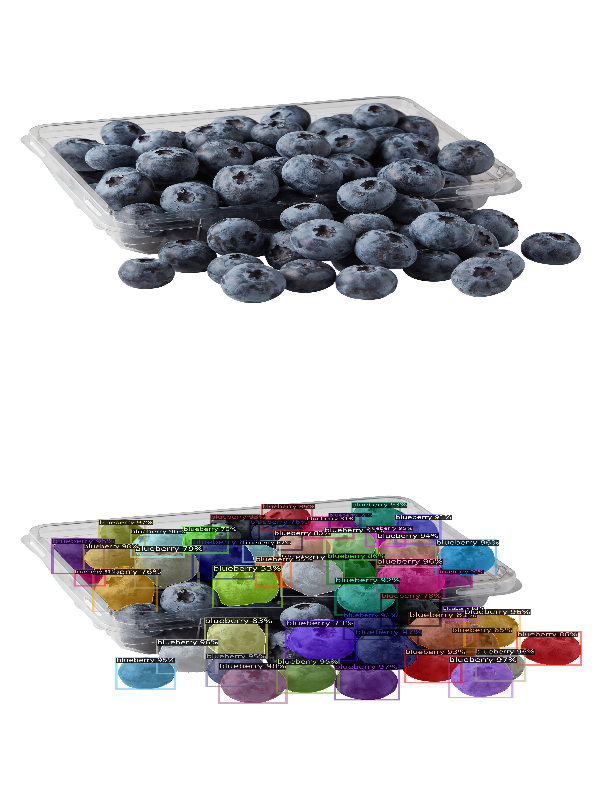

wrote .json file at  /content/drive/MyDrive/action-commonsense/action_images/boil/blueb.json
wrote .pkl file at  /content/drive/MyDrive/action-commonsense/action_features/blueb.pkl


In [ ]:
# cell 10
# will call all above functions for your uploaded image and
filename = 'boil/blueb.jpg'
IMAGE_DIR = '/content/drive/MyDrive/action-commonsense/action_images/'
OUTPUT_DIR = "/content/drive/MyDrive/action-commonsense/action_features/"
os.makedirs(OUTPUT_DIR, exist_ok=True)
combined_path = IMAGE_DIR+filename
displayim(combined_path)
gen_json(combined_path)
gen_pickle(combined_path,OUTPUT_DIR)

Showing input image and detected objects


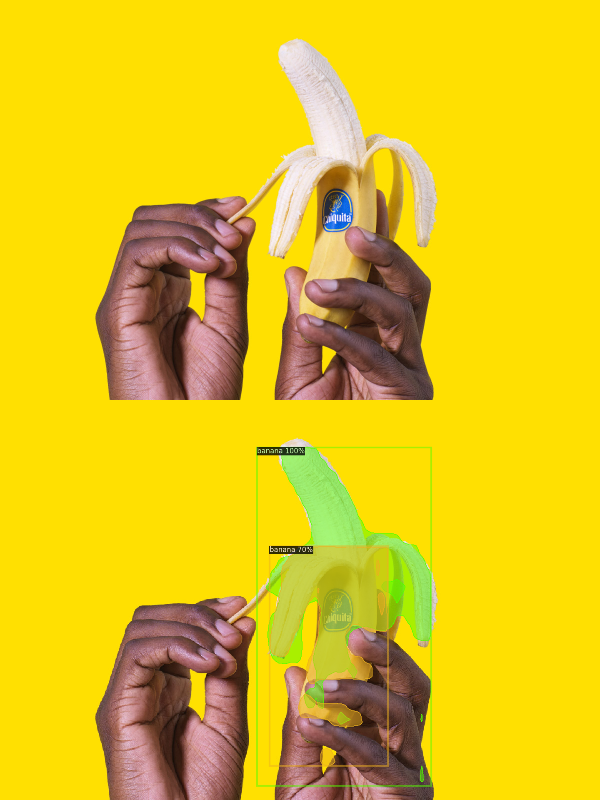

wrote .json file at  /content/drive/MyDrive/action-commonsense/action_images//cut/Ex5.json
wrote .pkl file at  /content/drive/MyDrive/action-commonsense/action_features/Ex5.pkl


In [ ]:
# cell 10
# will call all above functions for your uploaded image and
filename = '/cut/Ex5.jpg'
IMAGE_DIR = '/content/drive/MyDrive/action-commonsense/action_images/'
OUTPUT_DIR = "/content/drive/MyDrive/action-commonsense/action_features/"
os.makedirs(OUTPUT_DIR, exist_ok=True)
combined_path = IMAGE_DIR+filename
displayim(combined_path)
gen_json(combined_path)
gen_pickle(combined_path,OUTPUT_DIR)

/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Showing input image and detected objects


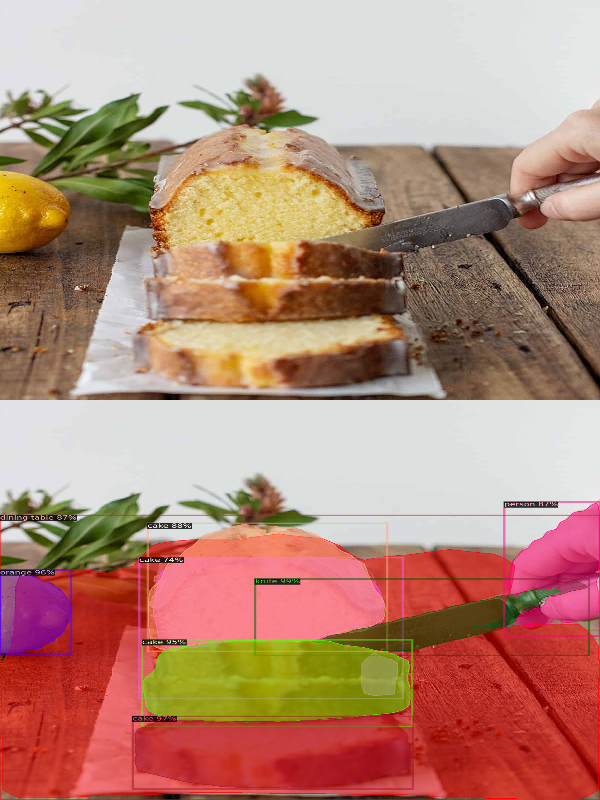

wrote .json file at  /content/drive/MyDrive/visual-comet/action_images//cut/Ex1..json
wrote .pkl file at  /content/drive/MyDrive/visual-comet/action_features/Ex1..pkl


In [ ]:
# cell 10
# will call all above functions for your uploaded image and
filename = '/cut/Ex1.jpeg'
IMAGE_DIR = '/content/drive/MyDrive/action-commonsense/action_images/'
OUTPUT_DIR = "/content/drive/MyDrive/action-commonsense/action_features/"
os.makedirs(OUTPUT_DIR, exist_ok=True)
combined_path = IMAGE_DIR+filename
displayim(combined_path)
gen_json(combined_path)
gen_pickle(combined_path,OUTPUT_DIR)

Showing input image and detected objects


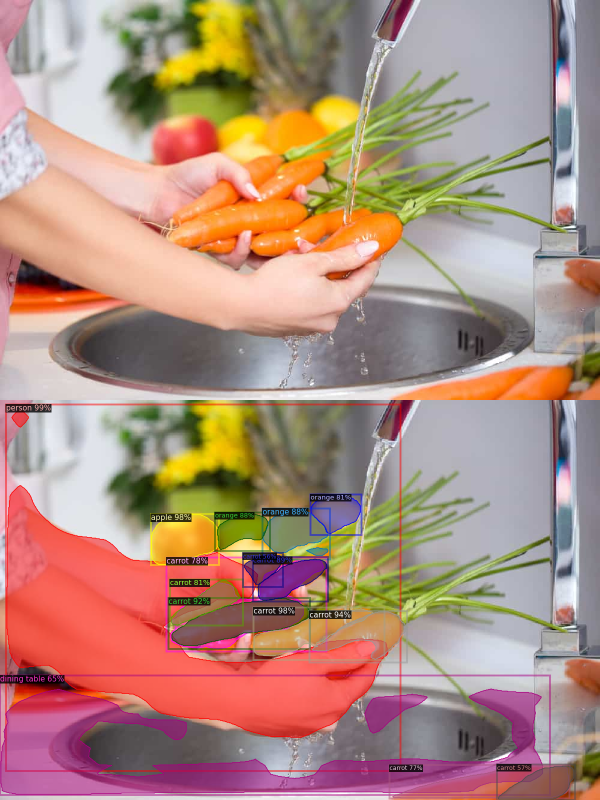

wrote .json file at  /content/drive/MyDrive/visual-comet/action_images//cut/Ex2.json
wrote .pkl file at  /content/drive/MyDrive/visual-comet/action_features/Ex2.pkl


In [ ]:
# cell 10
# will call all above functions for your uploaded image and
filename = '/cut/Ex2.jpg'
IMAGE_DIR = '/content/drive/MyDrive/action-commonsense/action_images/'
OUTPUT_DIR = "/content/drive/MyDrive/action-commonsense/action_features/"
os.makedirs(OUTPUT_DIR, exist_ok=True)
combined_path = IMAGE_DIR+filename
displayim(combined_path)
gen_json(combined_path)
gen_pickle(combined_path,OUTPUT_DIR)

Showing input image and detected objects


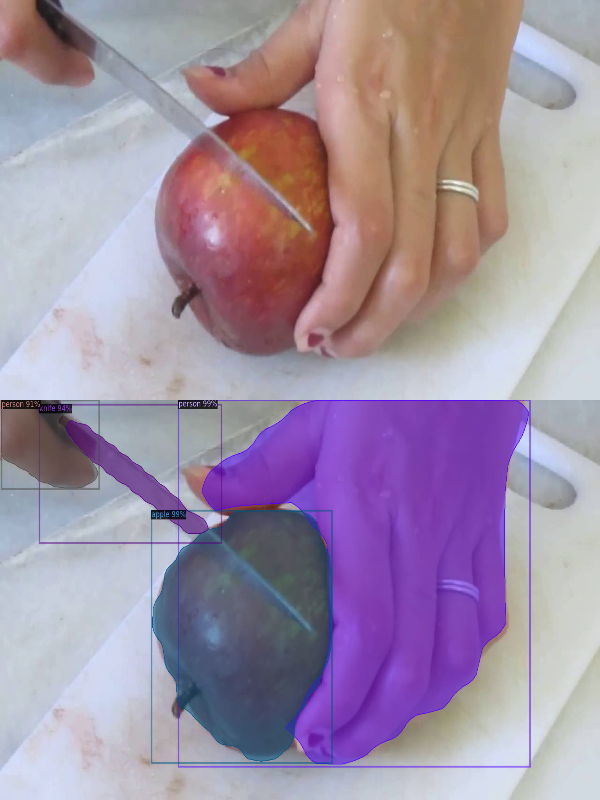

wrote .json file at  /content/drive/MyDrive/visual-comet/action_images//cut/Ex3.json
wrote .pkl file at  /content/drive/MyDrive/visual-comet/action_features/Ex3.pkl


In [ ]:
# cell 10
# will call all above functions for your uploaded image and
filename = '/cut/Ex3.jpg'
IMAGE_DIR = '/content/drive/MyDrive/action-commonsense/action_images/'
OUTPUT_DIR = "/content/drive/MyDrive/action-commonsense/action_features/"
os.makedirs(OUTPUT_DIR, exist_ok=True)
combined_path = IMAGE_DIR+filename
displayim(combined_path)
gen_json(combined_path)
gen_pickle(combined_path,OUTPUT_DIR)

Showing input image and detected objects


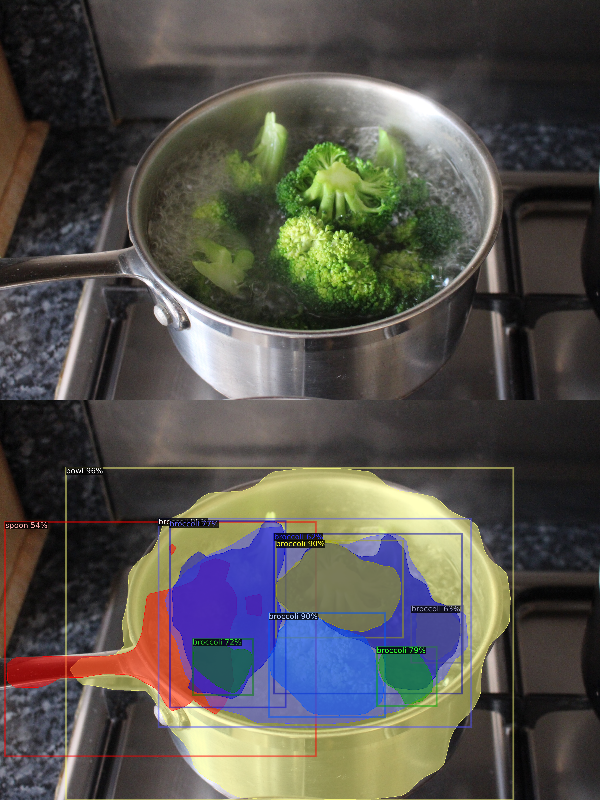

wrote .json file at  /content/drive/MyDrive/visual-comet/action_images//cut/Ex4.json
wrote .pkl file at  /content/drive/MyDrive/visual-comet/action_features/Ex4.pkl


In [ ]:
# cell 10
# will call all above functions for your uploaded image and
filename = '/cut/Ex4.jpg'
IMAGE_DIR = '/content/drive/MyDrive/action-commonsense/action_images/'
OUTPUT_DIR = "/content/drive/MyDrive/action-commonsense/action_features/"
os.makedirs(OUTPUT_DIR, exist_ok=True)
combined_path = IMAGE_DIR+filename
displayim(combined_path)
gen_json(combined_path)
gen_pickle(combined_path,OUTPUT_DIR)

Showing input image and detected objects


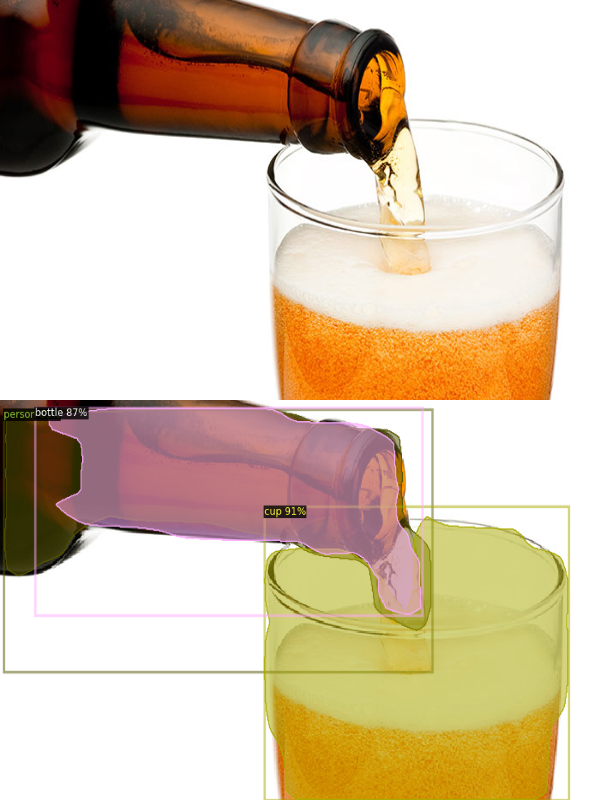

wrote .json file at  /content/drive/MyDrive/visual-comet/action_images//cut/Ex6.json
wrote .pkl file at  /content/drive/MyDrive/visual-comet/action_features/Ex6.pkl


In [ ]:
# cell 10
# will call all above functions for your uploaded image and
filename = '/cut/Ex6.jpg'
IMAGE_DIR = '/content/drive/MyDrive/action-commonsense/action_images/'
OUTPUT_DIR = "/content/drive/MyDrive/action-commonsense/action_features/"
os.makedirs(OUTPUT_DIR, exist_ok=True)
combined_path = IMAGE_DIR+filename
displayim(combined_path)
gen_json(combined_path)
gen_pickle(combined_path,OUTPUT_DIR)